# Airbnb Listings, EDA and Prediction: Toronto, Canada

---------

**Airbnb 2021 data was sourced from:**
http://insideairbnb.com/get-the-data.html



**Task:**
1. Explore Airbnb calendars data
2. Explore Airbnb listings data
3. Predict listing prices (Random Forest and LightGBM)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")

### Calendar

How busy is it for Airbnb hosts in Toronto?

In [2]:
calendar = pd.read_csv('calendar.csv.gz')

print('We have', calendar.date.nunique(), 
      'days and', calendar.listing_id.nunique(), 
      'unique listings in the calendar data.')

We have 366 days and 15298 unique listings in the calendar data.


In [3]:
calendar.date.min(), calendar.date.max()

('2021-07-05', '2022-07-05')

Calendar data covers one year time frame, that is, price and availability every day for the next one year.

In [4]:
calendar.isnull().sum()

listing_id           0
date                 0
available            0
price             2683
adjusted_price    2683
minimum_nights       7
maximum_nights       7
dtype: int64

In [5]:
calendar.shape

(5583778, 7)

In [6]:
calendar.head()

listing_id        date available    price adjusted_price  minimum_nights  \
0      456371  2021-07-05         f   $30.00         $30.00            30.0   
1       34646  2021-07-05         f  $118.00        $118.00            60.0   
2       34646  2021-07-06         f  $118.00        $118.00            60.0   
3       34646  2021-07-07         f  $118.00        $118.00            60.0   
4       34646  2021-07-08         t  $118.00        $118.00            60.0   

   maximum_nights  
0          1125.0  
1           730.0  
2           730.0  
3           730.0  
4           730.0

In [7]:
calendar.available.value_counts()

f    3547542
t    2036236
Name: available, dtype: int64

f (false) means not available, t(true) means available.

Find out daily average availability for one year. Convert available column to 0 if available and 1 if not.

In [8]:
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == 't' else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
calendar_new['date'] = pd.to_datetime(calendar_new['date'])

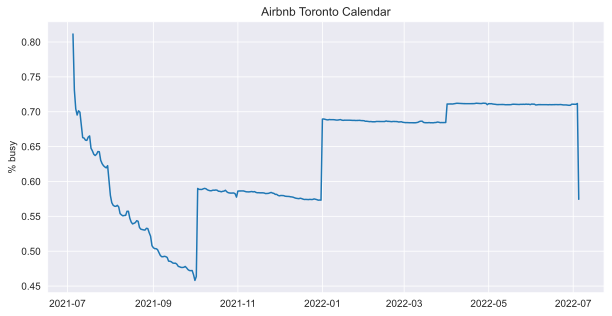

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Toronto Calendar')
plt.ylabel('% busy')
plt.show();

The busiest month in Toronto was July which has just passed.The next busy months seems after January and extend to the summer. 

### Price on the Calendar

How prices change over the year by month?

In [10]:
calendar.head()

listing_id        date available    price adjusted_price  minimum_nights  \
0      456371  2021-07-05         f   $30.00         $30.00            30.0   
1       34646  2021-07-05         f  $118.00        $118.00            60.0   
2       34646  2021-07-06         f  $118.00        $118.00            60.0   
3       34646  2021-07-07         f  $118.00        $118.00            60.0   
4       34646  2021-07-08         t  $118.00        $118.00            60.0   

   maximum_nights  
0          1125.0  
1           730.0  
2           730.0  
3           730.0  
4           730.0

Remove "$" symbol in price column and convert it to numeric, and convert date to datetime data type.

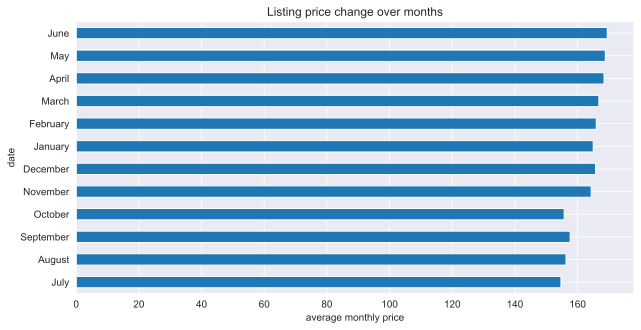

In [11]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'),
                                 sort=False)['price'].mean()
mean_of_month.plot(kind = 'barh' , figsize = (10,5))
plt.xlabel('average monthly price')
plt.title('Listing price change over months');

The Airbnb price in Toronto increases in the months of April, May and June.

In [12]:
calendar.head()

listing_id       date available  price adjusted_price  minimum_nights  \
0      456371 2021-07-05         f   30.0         $30.00            30.0   
1       34646 2021-07-05         f  118.0        $118.00            60.0   
2       34646 2021-07-06         f  118.0        $118.00            60.0   
3       34646 2021-07-07         f  118.0        $118.00            60.0   
4       34646 2021-07-08         t  118.0        $118.00            60.0   

   maximum_nights  
0          1125.0  
1           730.0  
2           730.0  
3           730.0  
4           730.0

In [13]:
calendar.drop(columns=['adjusted_price', 'minimum_nights','maximum_nights'], axis=1, inplace=True)

In [14]:
calendar['dayofweek'] = calendar['date'].dt.day_name()

In [15]:
calendar.head()

listing_id       date available  price  dayofweek
0      456371 2021-07-05         f   30.0     Monday
1       34646 2021-07-05         f  118.0     Monday
2       34646 2021-07-06         f  118.0    Tuesday
3       34646 2021-07-07         f  118.0  Wednesday
4       34646 2021-07-08         t  118.0   Thursday

How price changes during day of week?

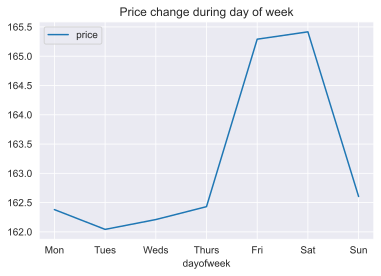

In [16]:
calendar['dayofweek'] = calendar.date.dt.day_name()
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
price_week=calendar[['dayofweek','price']]
price_week = calendar.groupby(['dayofweek']).mean().reindex(cats)
price_week.drop('listing_id', axis=1, inplace=True)
price_week.plot()
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Price change during day of week');

Fridays and Saturdays are over $3 more expensive than the rest of the week. **We dont see a material price difference during Covid-19 during the day of week.**

### Listings

#### Number of listings in each neighbourhood

In [17]:
listings = pd.read_csv('listings.csv.gz')
print('We have', listings.id.nunique(), 'listings in the listing data.')

We have 15298 listings in the listing data.


In [18]:
listings.head(3)

id                         listing_url       scrape_id last_scraped  \
0   1419   https://www.airbnb.com/rooms/1419  20210704233324   2021-07-05   
1   8077   https://www.airbnb.com/rooms/8077  20210704233324   2021-07-06   
2  23691  https://www.airbnb.com/rooms/23691  20210704233324   2021-07-06   

                                 name  \
0     Beautiful home in amazing area!   
1  Downtown Harbourfront Private Room   
2     Queen Bedroom close to downtown   

                                         description  \
0  This large, family home is located in one of T...   
1  Guest room in a luxury condo with access to al...   
2  <b>The space</b><br />Nestled in the middle of...   

                               neighborhood_overview  \
0  The apartment is located in the Ossington stri...   
1                                                NaN   
2                                                NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/76206750/d643...     1565   
1  https://a0.muscache.com/pictures/11780344/141c...    22795   
2  https://a0.muscache.com/pictures/615528/d09ab3...    93825   

                                  host_url  ... review_scores_communication  \
0   https://www.airbnb.com/users/show/1565  ...                        5.00   
1  https://www.airbnb.com/users/show/22795  ...                        4.90   
2  https://www.airbnb.com/users/show/93825  ...                        4.93   

  review_scores_location review_scores_value license instant_bookable  \
0                   5.00                5.00     NaN                f   
1                   4.92                4.83     NaN                t   
2                   4.34                4.73     NaN                t   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              1                                           1   
1                              2                                           1   
2                              2                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            1   
2                                            2   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.10  
1                                           0              1.57  
2                                           0              1.80  

[3 rows x 74 columns]

In [19]:
listings.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

id
neighbourhood_cleansed                   
Waterfront Communities-The Island    2703
Niagara                               632
Church-Yonge Corridor                 520
Annex                                 511
Bay Street Corridor                   470
Kensington-Chinatown                  415
Trinity-Bellwoods                     415
Dovercourt-Wallace Emerson-Junction   374
Willowdale East                       371
Moss Park                             354

The neighbourhood that has the highest number of listings is Waterfront Communities-The Island, and almost four times more than the second most neighbourhood (Niagara).

### review score rating

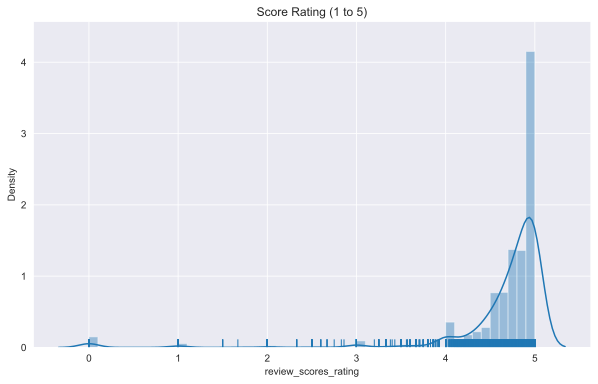

In [20]:
plt.figure(figsize=(10,6))
sns.distplot(listings.review_scores_rating.dropna(), rug=True)
sns.despine()
plt.title('Score Rating (1 to 5)')
plt.show();

In [21]:
listings.review_scores_rating.describe()

count    11714.000000
mean         4.645274
std          0.735647
min          0.000000
25%          4.630000
50%          4.840000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

As expected, most of reviewers leave high scores. Average rating is 4.6

### Exploring the price

In [22]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)

listings['price'].describe()

count    15298.000000
mean       150.527912
std        363.959142
min          0.000000
25%         65.000000
50%        100.000000
75%        156.000000
max      13000.000000
Name: price, dtype: float64

The most expensive Airbnb listing in Toronto is at $13,000/night. Looks like a Penthouse.

In [23]:
listings.iloc[np.argmax(listings['price'])]

id                                                                              20653172
listing_url                                        https://www.airbnb.com/rooms/20653172
scrape_id                                                                 20210704233324
last_scraped                                                                  2021-07-05
name                                            Modern Upscale Condo in downtown Toronto
                                                                  ...                   
calculated_host_listings_count                                                         2
calculated_host_listings_count_entire_homes                                            2
calculated_host_listings_count_private_rooms                                           0
calculated_host_listings_count_shared_rooms                                            0
reviews_per_month                                                                   0.09
Name: 4826, Length: 7

I decided to remove (254) listings that exceed $600/night, as well as 2 listings at price 0, for the following exploratory analysis.

In [24]:
listings.loc[listings['price'] > 600]['price'].describe()

count      254.000000
mean      1723.539370
std       2233.506972
min        615.000000
25%        782.500000
50%        999.000000
75%       1603.250000
max      13000.000000
Name: price, dtype: float64

In [25]:
listings.loc[listings['price'] == 0]['price'].count()

2

#### Listings price distribution after removing outliers

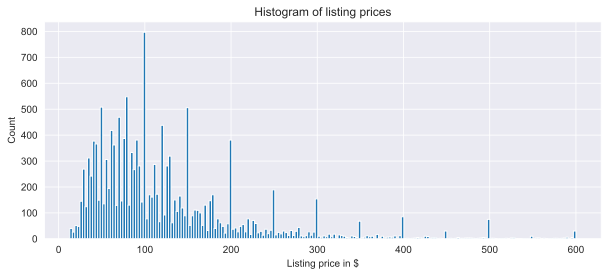

In [26]:
plt.figure(figsize=(10, 4))
listings.loc[(listings.price <= 600) & (listings.price > 0)].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices');

#### Neighbourhood vs. Price

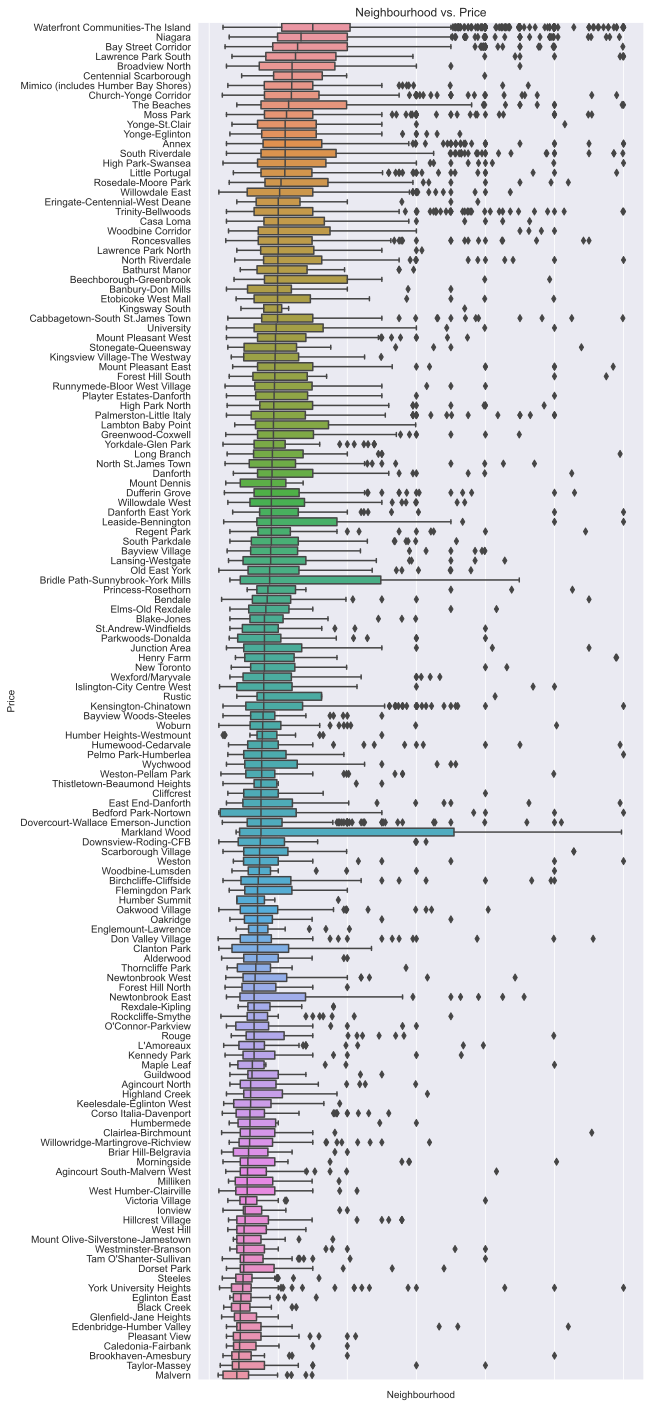

In [27]:
sort_price = listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index

plt.figure(figsize=(8, 25))
sns.boxplot(x='price', y='neighbourhood_cleansed', data=listings.loc[(listings.price <= 600) & (listings.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel('Neighbourhood',fontsize = 10)
ax.set_ylabel('Price', fontsize = 10)
plt.title('Neighbourhood vs. Price')
plt.show();

Not only **Waterfront Communities-The Island** has the highest number of listings, it also enjoys the highest median price, and **Malvern** has the lowest median price.

#### host vs. price

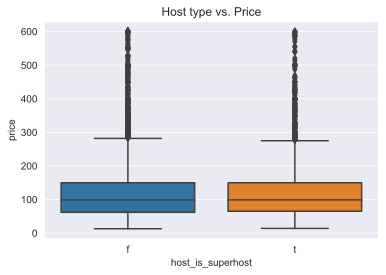

In [28]:
sns.boxplot(y='price', x='host_is_superhost', data=listings.loc[(listings.price <= 600) & (listings.price > 0)])
plt.title('Host type vs. Price')
plt.show();

During Covid-19 superhost doesnt enjoy a higher median price than normal host.

#### property type vs. price

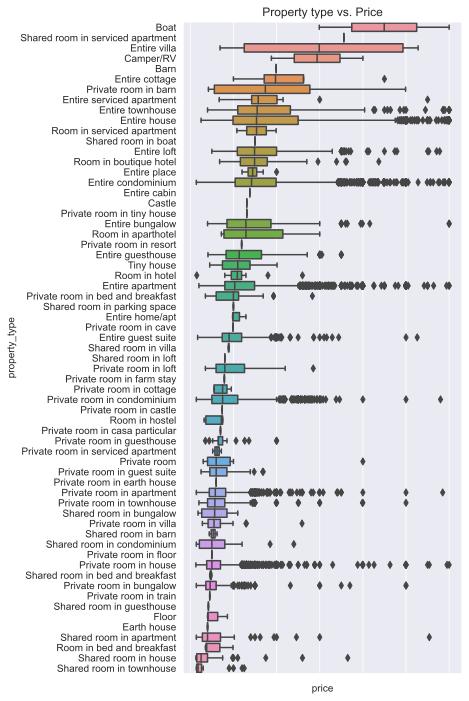

In [29]:
sort_price = listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
plt.figure(figsize=(5, 12))
sns.boxplot(x='price', y='property_type', data=listings.loc[(listings.price <= 600) & (listings.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.title('Property type vs. Price')
plt.show();

It is interesting to note, that the most expensive proerty is boat during Covid-19 time.

When we look at the median price for each property type, we have to be careful that we can't say "The second most expensive property type is Sahred room in Service Appartment", because it has only one listing.

In [30]:
listings.property_type.value_counts()

Entire condominium              3656
Entire apartment                3150
Private room in house           2337
Entire house                    1630
Private room in apartment       1029
                                ... 
Shared room in parking space       1
Private room in resort             1
Shared room in loft                1
Entire cabin                       1
Private room in castle             1
Name: property_type, Length: 63, dtype: int64

#### room type vs. price

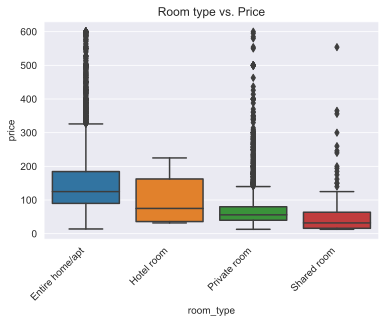

In [31]:
sort_price = listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                    .groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='room_type', data=listings.loc[(listings.price <= 600) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Room type vs. Price')
plt.show();

This goes without saying, entire room/apt has a a much higher median price than the other room types.

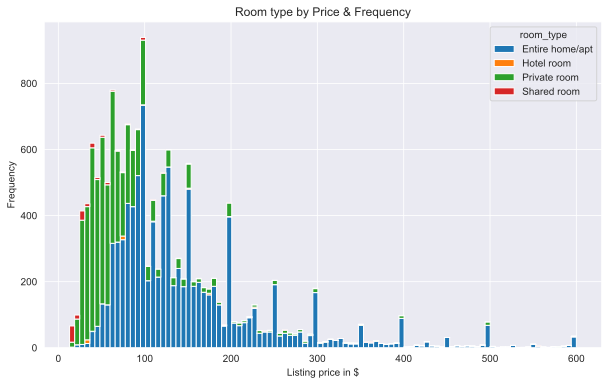

In [32]:
listings.loc[(listings.price <= 600) & (listings.price > 0)].pivot(columns = 'room_type', 
                                                                   values = 'price').plot.hist(stacked = True, 
                                                                                               bins=100,
                                                                                               figsize=(10,6))

plt.xlabel('Listing price in $')
plt.title('Room type by Price & Frequency');

Entire home/apt also has the most number of listings. Inside Airbnb has indicated that Entire homes or apartments highly available year-round for tourists, probably don't have the owner present, could be illegal, and more importantly, are displacing residents. 

#### Amenities

The amenities text field needs some cleaning.

In [33]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")

In [34]:
listings['amenities'].head()

0    [Smoke alarm, Air conditioning, First aid kit,...
1    [Smoke alarm, Elevator, Air conditioning, Free...
2    [Hangers, Stove, Dedicated workspace, Hair dry...
3    [Hangers, Stove, Dedicated workspace, Hot wate...
4    [Hangers, Elevator, Stove, Dedicated workspace...
Name: amenities, dtype: object

#### Top 20 most common amenities

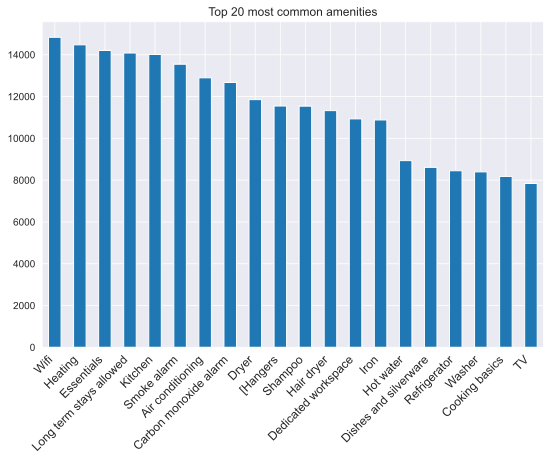

In [35]:
plt.figure(figsize=(9, 6))

pd.Series(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar')

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.title('Top 20 most common amenities')
plt.show();

Wifi, heating, essentials are among the most common amenities.

#### Amenities vs. price top 20

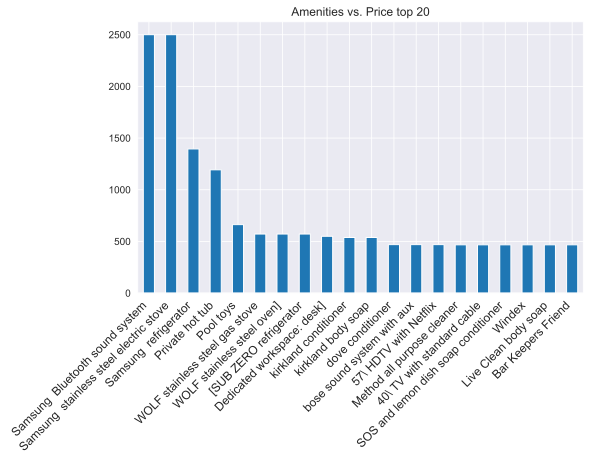

In [36]:
plt.figure(figsize=(8, 5))

amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))
amenity_prices = [(amn, listings[listings['amenities'].map(lambda amns: amn in amns)]['price'].mean()) for amn in amenities if amn != ""]
amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])

amenity_srs.sort_values(ascending=False)[:20].plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.title('Amenities vs. Price top 20')
plt.show();

Interesting, amenities feature does seem to have some relationship with price.

#### Number of beds vs. price

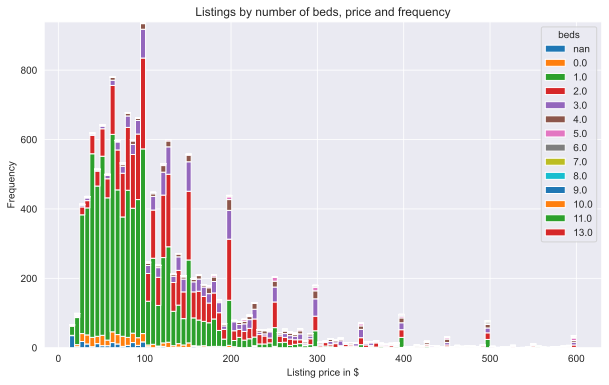

In [37]:
listings.loc[(listings.price <= 600) & (listings.price > 0)].pivot(columns = 'beds',
                                                                   values = 'price').plot.hist(stacked = True,bins=100, 
                                                                                               figsize=(10,6))
plt.xlabel('Listing price in $')
plt.title('Listings by number of beds, price and frequency');

Vast majority of the listings have one bed, the one-bed listing prices have a very wide range. There are listings that have no bed.

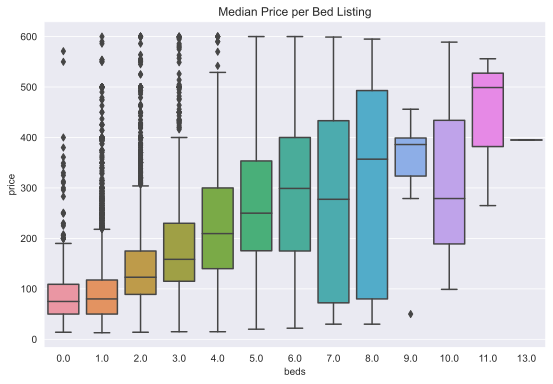

In [38]:
plt.figure(figsize=(9, 6))

sns.boxplot(y='price', x='beds', data = listings.loc[(listings.price <= 600) & (listings.price > 0)])

plt.title('Median Price per Bed Listing')
plt.show();

Interesting to discover that the median price for no bed listings is same as 1-bed listings, and median price for 10-bed listings is very low. The higest price is for 11 beds. It interesting to see 10 and 7 beds properties have similar price. There is only one property with 13 beds.



#### Numeric features

We select several numeric features and try to explore them all together.

In [39]:
# First, lets clean up the issues with the bathroom data
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip('bath')
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip('baths')
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip(' shared')
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip(' private')
listings['bathrooms_text'] = listings['bathrooms_text'].str.replace('Shared half-', '0.5')
listings['bathrooms_text'] = listings['bathrooms_text'].str.replace('Private half-', '0.5')
listings['bathrooms_text'] = listings['bathrooms_text'].str.replace('Half-', '0.5')
listings['bathrooms_text'] = listings['bathrooms_text'].astype(float)
listings['bathrooms_text'].value_counts()
#listings.rename(columns = {'bathrooms_text':'bathrooms'}, inplace = True)


1.0    11488
2.0     2022
1.5     1015
2.5      260
3.0      240
3.5       90
0.0       47
4.0       40
4.5       32
0.5       28
5.0        8
5.5        7
6.5        3
6.0        3
7.5        1
Name: bathrooms_text, dtype: int64

In [40]:
col = ['host_listings_count', 'accommodates','bedrooms', 'beds', 'price', 'number_of_reviews', 
       'review_scores_rating', 'reviews_per_month','bathrooms_text']

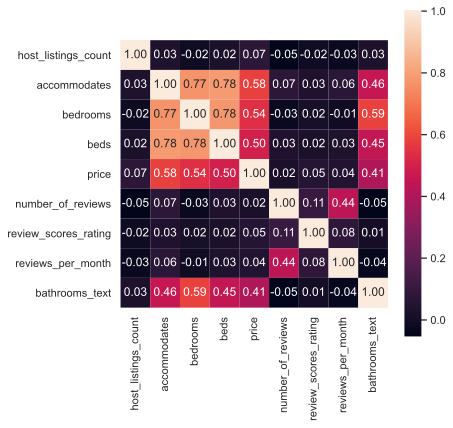

In [41]:
corr = listings.loc[(listings.price <= 600) & (listings.price > 0)][col].dropna().corr()
plt.figure(figsize = (6,6))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

There are some not bad news such as number of bedrooms and accommodates seem to be correlated with price.

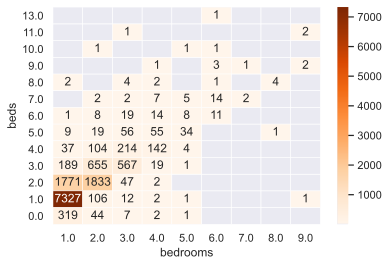

In [42]:
sns.heatmap(listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                .groupby(['beds', 'bedrooms'])\
                .count()['price']\
                .reset_index()\
                .pivot('beds', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Oranges", fmt='.0f', annot=True, linewidths=0.5)
plt.show();

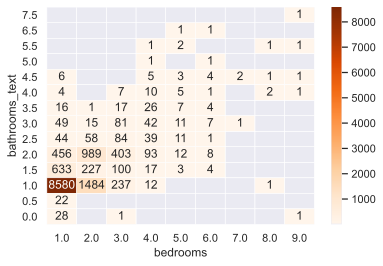

In [43]:
g=sns.heatmap(listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                .groupby(['bathrooms_text', 'bedrooms'])\
                .count()['price']\
                .reset_index()\
                .pivot('bathrooms_text', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Oranges", fmt='.0f', annot=True, linewidths=0.5)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.show();

Vast majority of listings have one bedroom and 1 bed.

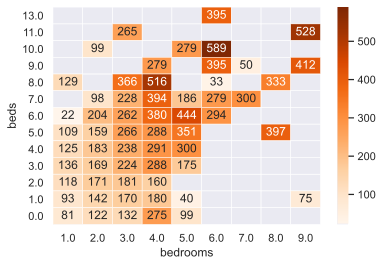

In [44]:
sns.heatmap(listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                .groupby(['beds', 'bedrooms'])\
                .mean()['price']\
                .reset_index()\
                .pivot('beds', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Oranges", fmt='.0f', annot=True, linewidths=0.5)
plt.show();

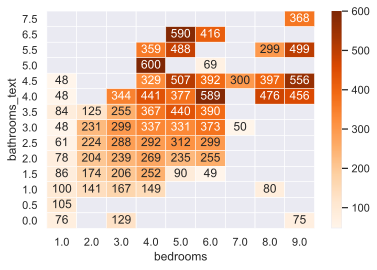

In [71]:
g=sns.heatmap(listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                .groupby(['bathrooms_text', 'bedrooms'])\
                .mean()['price']\
                .reset_index()\
                .pivot('bathrooms_text', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Oranges", fmt='.0f', annot=True, linewidths=0.5)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.show();

It looks like listings with 6 bedrooms and 10 beds have the highest median price. But we must be skeptical about this finding because from the above single graph, we don't know how many listings in this category.

## Modeling Lising Prices

### Data preprocessing and feature engineering

In [46]:
listings = pd.read_csv('listings.csv.gz')

Processing price feature. The feature we are going to model and predict.

In [47]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)
listings = listings.loc[(listings.price <= 600) & (listings.price > 0)]

In [48]:
# we have some issues with 
listings.bathrooms_text

0               3 baths
1             1.5 baths
2         1 shared bath
3                1 bath
4                1 bath
              ...      
15293            1 bath
15294    1 private bath
15295         1.5 baths
15296            1 bath
15297            1 bath
Name: bathrooms_text, Length: 15042, dtype: object

In [49]:
listings['bathrooms_text'].value_counts()

1 bath               7726
1 shared bath        2375
2 baths              1657
1 private bath       1308
1.5 baths             653
1.5 shared baths      346
2 shared baths        314
2.5 baths             212
3 baths               166
3.5 baths              58
3 shared baths         42
2.5 shared baths       26
0 shared baths         26
4 baths                26
4.5 baths              22
0 baths                21
Shared half-bath       13
3.5 shared baths       13
Private half-bath       7
Half-bath               6
5.5 baths               5
4 shared baths          4
5 baths                 2
6.5 baths               2
7.5 baths               1
Name: bathrooms_text, dtype: int64

In [50]:
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip('bath')
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip('baths')
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip(' shared')
listings['bathrooms_text'] = listings['bathrooms_text'].str.rstrip(' private')
listings['bathrooms_text'] = listings['bathrooms_text'].str.replace('Shared half-', '0.5')
listings['bathrooms_text'] = listings['bathrooms_text'].str.replace('Private half-', '0.5')
listings['bathrooms_text'] = listings['bathrooms_text'].str.replace('Half-', '0.5')
listings['bathrooms_text'] = listings['bathrooms_text'].astype(float)

In [51]:
listings['bathrooms_text'].value_counts()

1.0    11409
2.0     1971
1.5      999
2.5      238
3.0      208
3.5       71
0.0       47
4.0       30
0.5       26
4.5       22
5.5        5
6.5        2
5.0        2
7.5        1
Name: bathrooms_text, dtype: int64

Term document matrix for amenities feature.

In [52]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")

In [53]:
listings.amenities.head()

0    [Smoke alarm, Air conditioning, First aid kit,...
1    [Smoke alarm, Elevator, Air conditioning, Free...
2    [Hangers, Stove, Dedicated workspace, Hair dry...
3    [Hangers, Stove, Dedicated workspace, Hot wate...
4    [Hangers, Elevator, Stove, Dedicated workspace...
Name: amenities, dtype: object

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(listings['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
# df_amenities = df_amenities.drop('',1)

In [55]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

In [56]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'instant_bookable','picture_url', 'has_availability']
for c in columns:
    listings[c] = listings[c].replace('f',0,regex=True)
    listings[c] = listings[c].replace('t',1,regex=True)

Replace the values in the following feature to 0 if "f", to 1 if "t".

The following are the numeric features we will be using.

In [57]:
listings.head(2).T

0                                                  1
id                                                                                         1419                                               8077
listing_url                                                   https://www.airbnb.com/rooms/1419                  https://www.airbnb.com/rooms/8077
scrape_id                                                                        20210704233324                                     20210704233324
last_scraped                                                                         2021-07-05                                         2021-07-06
name                                                            Beautiful home in amazing area!                 Downtown Harbourfront Private Room
description                                   This large, family home is located in one of T...  Guest room in a luxury condo with access to al...
neighborhood_overview                         The apartment is located in the Ossington stri...                                                NaN
picture_url                                                                                   1                                                  1
host_id                                                                                    1565                                              22795
host_url                                                 https://www.airbnb.com/users/show/1565            https://www.airbnb.com/users/show/22795
host_name                                                                             Alexandra                                     Kathie & Larry
host_since                                                                           2008-08-08                                         2009-06-22
host_location                                               Vancouver, British Columbia, Canada                           Toronto, Ontario, Canada
host_about                                    I live in Vancouver, Canada with my husband an...  My husband and I have been airbnb host for alm...
host_response_time                                                                          NaN                                                NaN
host_response_rate                                                                          NaN                                                NaN
host_acceptance_rate                                                                        NaN                                                NaN
host_is_superhost                                                                             0                                                  0
host_thumbnail_url                            https://a0.muscache.com/im/pictures/user/7aeea...  https://a0.muscache.com/im/pictures/user/9a077...
host_picture_url                              https://a0.muscache.com/im/pictures/user/7aeea...  https://a0.muscache.com/im/pictures/user/9a077...
host_neighbourhood                                                             Commercial Drive                                       Harbourfront
host_listings_count                                                                           1                                                  2
host_total_listings_count                                                                     1                                                  2
host_verifications                            ['email', 'phone', 'reviews', 'jumio', 'govern...          ['email', 'phone', 'facebook', 'reviews']
host_has_profile_pic                                                                          1                                                  1
host_identity_verified                                                                        1                                                  0
neighbourhood                                                          Toronto, Ontario, Canada                              

In [58]:
listings_new = listings[['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic', 
                         'instant_bookable', 'host_listings_count', 'host_total_listings_count', 'minimum_nights',
                         'bedrooms', 'number_of_reviews','review_scores_rating', 'price','bathrooms_text',
                         'accommodates','beds','review_scores_accuracy','review_scores_cleanliness','reviews_per_month']]

Fill the missing values in the numeric features with median.

In [59]:
for col in listings_new.columns[listings_new.isnull().any()]:
    print(col)

host_is_superhost
host_identity_verified
host_has_profile_pic
host_listings_count
host_total_listings_count
bedrooms
review_scores_rating
bathrooms_text
beds
review_scores_accuracy
review_scores_cleanliness
reviews_per_month


In [60]:
listings_new.isnull().sum()

host_is_superhost               4
host_identity_verified          4
host_has_profile_pic            4
instant_bookable                0
host_listings_count             4
host_total_listings_count       4
minimum_nights                  0
bedrooms                     1146
number_of_reviews               0
review_scores_rating         3480
price                           0
bathrooms_text                 11
accommodates                    0
beds                          213
review_scores_accuracy       3651
review_scores_cleanliness    3649
reviews_per_month            3480
dtype: int64

In [61]:
for col in listings_new.columns[listings_new.isnull().any()]:
    listings_new[col] = listings_new[col].fillna(listings_new[col].median())

Processing Categorical features

In [62]:
for cat_feature in ['property_type', 'room_type', 'neighbourhood_cleansed', 'property_type',
                    'room_type', 'name', 'host_about','neighbourhood']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[cat_feature])], axis=1)

Adding amenities feature

In [63]:
listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')

Data preprocessing and feature engineering done!

### Random Forest

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 60.613
R^2 test: 0.500


#### Feature importance of Random Forest

In [65]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

est_int     coefs
7                                               bedrooms  0.212494
10                                        bathrooms_text  0.090789
11                                          accommodates  0.049125
79                                       Entire home/apt  0.037165
286                                      Entire home/apt  0.031890
205                    Waterfront Communities-The Island  0.022631
15                                     reviews_per_month  0.013680
9                                   review_scores_rating  0.011486
6                                         minimum_nights  0.011316
14                             review_scores_cleanliness  0.010994
8                                      number_of_reviews  0.010380
12                                                  beds  0.010356
13                                review_scores_accuracy  0.008705
5                              host_total_listings_count  0.008176
4                                    host_listings_count  0.008125
18911  None of the listings are mine. I help househol...  0.006055
24                                    Entire condominium  0.004425
170                                              Niagara  0.004267
231                                   Entire condominium  0.004153
19463  We are a retired couple, regular yoga practiti...  0.003786

### LightGBM

In [66]:
from lightgbm import LGBMRegressor
import re
listings_new = listings_new.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }

In [67]:
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')

In [68]:
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=0, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_train.values, y_train.values, **fit_params)

Training until validation scores don't improve for 20 rounds
[100]	valid's rmse: 66.0535
[200]	valid's rmse: 62.0958
[300]	valid's rmse: 60.8819
[400]	valid's rmse: 60.2328
[500]	valid's rmse: 59.8437
[600]	valid's rmse: 59.6229
[700]	valid's rmse: 59.5143
[800]	valid's rmse: 59.4602
Early stopping, best iteration is:
[851]	valid's rmse: 59.4143


LGBMRegressor_GainFE(colsample_bytree=0.9, learning_rate=0.01, max_depth=20,
                     metric='rmse', n_estimators=1000, n_jobs=4, num_leaves=25,
                     random_state=0, subsample=0.9)

In [69]:
y_pred = clf.predict(X_test.values)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

R^2 test: 0.520


#### Feature importance of LightGBM

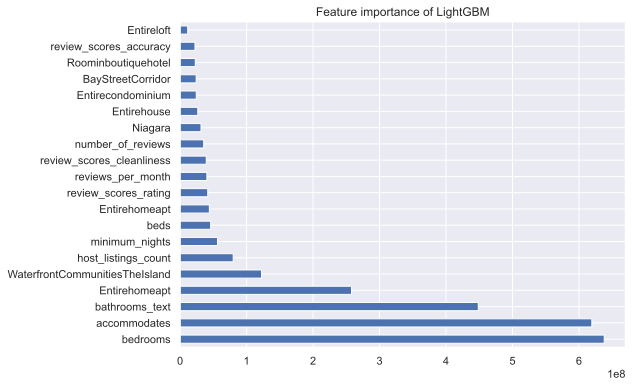

In [72]:
feat_imp = pd.Series(clf.feature_importances_, index=x.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,6))
plt.title('Feature importance of LightGBM');